In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, SimpleRNN
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
for module in np, pd, tf:
     print (module.__name__, module.__version__)

numpy 1.21.4
pandas 1.3.4
tensorflow 2.7.0


In [3]:
# 这两行代码解决 plt 中文显示的问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [4]:
stock = pd.read_csv('../dataset/600031.csv')  # 读取股票文件
# stock = stock.drop(['成交额'],axis=1)

In [5]:
stock.head()

,日期,开盘,收盘,最高,最低,成交量,成交额,振幅,涨跌幅,涨跌额,换手率
0,2020-11-09,27.80,27.54,28.14,26.89,856249,2348800992,4.55,0.18,0.05,1.01
1,2020-11-10,27.98,27.32,27.98,26.91,558824,1523209504,3.89,-0.80,-0.22,0.66
2,2020-11-11,27.33,28.31,28.86,27.21,1015374,2873205488,6.04,3.62,0.99,1.20
3,2020-11-12,28.31,28.70,28.88,27.91,718595,2041558432,3.43,1.38,0.39,0.85
4,2020-11-13,28.28,28.16,28.50,27.60,674807,1888773520,3.14,-1.88,-0.54,0.80


### 用多特征预测股价
### 将数据集分成训练集：测试集 == 4:1

In [6]:
# 取除日期外全部特征
training_set = stock.iloc[0:int(len(stock) / 5 * 4), 1:].values
test_set = stock.iloc[int(len(stock) / 5 * 4):, 1:].values

In [7]:
training_set.shape , test_set.shape

((201, 10), (51, 10))

# 归一化处理（进行缩放）

In [8]:
# 归一化
sc = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
# 缩放
training_set_scaled = sc.fit_transform(training_set)  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
test_set = sc.transform(test_set)  # 利用训练集的属性对测试集进行归一化

In [9]:
# 参数设置
# 步进值
seq_len = 5

# 训练集处理

In [10]:
x_train = []
y_train = []

# 数据进行分组
for i in range(seq_len, len(training_set_scaled)):
    # 全部特征
    x_train.append(training_set_scaled[i - seq_len:i, 0:])
    # 收盘价
    y_train.append(training_set_scaled[i, list(stock.iloc[0:int(len(stock) / 5 * 4), 1:].columns).index('收盘')])

# 对训练集进行打乱
np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)

# 将训练集由list格式变为array格式
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], seq_len, training_set.shape[1]))

# 测试集处理

In [11]:
x_test = []
y_test = []

# 利用for循环，遍历整个测试集，提取测试集中连续5天的开盘价作为输入特征x_train，第6天的数据作为标签
for i in range(seq_len, len(test_set)):
    # 全部特征
    x_test.append(test_set[i - seq_len:i, 0:])
    # 收盘价
    y_test.append(test_set[i, list(stock.iloc[0:int(len(stock) / 5 * 4), 1:].columns).index('收盘')])

    # 测试集变array并reshape为符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], seq_len, test_set.shape[1]))

# 构建模型

### 序列化建模，一般步骤为：

　　* 1、实例化一个Sequential类，该类是继承于Model类；

　　* 2、添加所需要的神经网络层；

　　* 3、用compile进行编译模型；

　　* 4、用fit训练模型；

　　* 5、用predict预测。

In [12]:
model = tf.keras.Sequential([
    SimpleRNN(80, return_sequences=True),
    Dropout(0.2),
    SimpleRNN(100),
    Dropout(0.2),
    Dense(1)
])

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss='mean_squared_error')  
# 损失函数用均方误差
# 该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值

# 预测一次，并保存预测结构，用于之后的验证

In [14]:
checkpoint_save_path = "./checkpoint/rnn_stock.ckpt"
if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

# 参数详解：
* x=None, #输入的x值
* y=None, #输入的y标签值
* batch_size=None, #整数 ，每次梯度更新的样本数即批量大小。未指定，默认为32。
* epochs=1, #迭代次数
* verbose=1, #整数，代表以什么形式来展示日志状态，
* verbose = 0 为不在标准输出流输出日志信息，verbose = 1 为输出进度条记录，verbose = 2 为每个epoch输出一行记录
* callbacks=None, #回调函数，这个list中的回调函数将会在训练过程中的适当时机被调用，参考回调函数
* validation_split=0.0, #浮点数0-1之间，用作验证集的训练数据的比例。模型将分出一部分不会被训练的验证数据，并将在每一轮结束时评估这些验证数据的误差和任何其他模型指标。
* validation_data=None, #这个参数会覆盖 validation_split
   即两个函数只能存在一个，它的输入为元组 (x_val，y_val)，这作为验证数据。
* shuffle=True, #布尔值。是否在每轮迭代之前混洗数据
* class_weight=None,
* sample_weight=None, 
* initial_epoch=0, 
* steps_per_epoch=None, #一个epoch包含的步数（每一步是一个batch的数据送入）
   当使用如TensorFlow数据Tensor之类的输入张量进行训练时，默认的None代表自动分割，即数据集样本数/batch样本数。
* validation_steps=None, #在验证集上的step总数，仅当steps_per_epoch被指定时有用。
* validation_freq=1, #指使用验证集实施验证的频率。当等于1时代表每个epoch结束都验证一次
* max_queue_size=10,
* workers=1,
* use_multiprocessing=False   

In [15]:
# 训练参数
batch_size = 64
epochs = 100
validation_freq=1
# 等等

Epoch 1/100
4/4 [==============================] - 4s 199ms/step - loss: 0.8071 - val_loss: 0.2196
Epoch 2/100
4/4 [==============================] - 0s 30ms/step - loss: 0.3128 - val_loss: 0.1744
Epoch 3/100
4/4 [==============================] - 0s 31ms/step - loss: 0.5727 - val_loss: 0.0119
Epoch 4/100
4/4 [==============================] - 0s 18ms/step - loss: 0.1699 - val_loss: 0.1061
Epoch 5/100
4/4 [==============================] - 0s 20ms/step - loss: 0.3272 - val_loss: 0.0133
Epoch 6/100
4/4 [==============================] - 0s 24ms/step - loss: 0.1565 - val_loss: 0.0739
Epoch 7/100
4/4 [==============================] - 0s 25ms/step - loss: 0.2358 - val_loss: 0.0192
Epoch 8/100
4/4 [==============================] - 0s 24ms/step - loss: 0.1259 - val_loss: 0.0264
Epoch 9/100
4/4 [==============================] - 0s 34ms/step - loss: 0.1868 - val_loss: 0.0106
Epoch 10/100
4/4 [==============================] - 0s 23ms/step - loss: 0.0981 - val_loss: 0.0113
Epoch 11/100
4/4 [

Epoch 83/100
4/4 [==============================] - 0s 21ms/step - loss: 0.0175 - val_loss: 6.4819e-04
Epoch 84/100
4/4 [==============================] - 0s 26ms/step - loss: 0.0178 - val_loss: 0.0013
Epoch 85/100
4/4 [==============================] - 0s 29ms/step - loss: 0.0191 - val_loss: 9.8184e-04
Epoch 86/100
4/4 [==============================] - 0s 28ms/step - loss: 0.0205 - val_loss: 6.6361e-04
Epoch 87/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0194 - val_loss: 0.0010
Epoch 88/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0213 - val_loss: 0.0017
Epoch 89/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0207 - val_loss: 0.0026
Epoch 90/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0255 - val_loss: 0.0029
Epoch 91/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0230 - val_loss: 7.9745e-04
Epoch 92/100
4/4 [==============================] - 0s 19ms/step - loss: 0.0185 - val_loss: 9

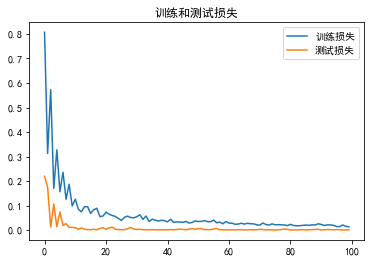

In [16]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss')

_model = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), validation_freq=validation_freq,
                   callbacks=[cp_callback])

model.summary()

file = open('./weights.txt', 'w')  # 参数提取
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

loss = _model.history['loss']
val_loss = _model.history['val_loss']

plt.plot(loss, label='训练损失')
plt.plot(val_loss, label='测试损失')
plt.title('训练和测试损失')
plt.legend()
plt.show()

In [17]:
# 预测
# 测试集输入模型进行预测
predicted_stock_price = model.predict(x_test)

In [18]:
# 归一时是对所有数据列进行的归一
# 补充数据列之后才能进行反归一
predicted_df = pd.DataFrame(test_set[seq_len:])
predicted_df.iloc[:, list(stock.iloc[0:int(len(stock) / 5 * 4), 1:].columns).index('收盘')] = predicted_stock_price
predicted_df.head()
predicted_set = predicted_df.values
# 对预测数据还原---从（0，1）反归一化到原始范围
predicted_stock_price = sc.inverse_transform(predicted_set)
# 对真实数据还原---从（0，1）反归一化到原始范围
real_stock_price = sc.inverse_transform(test_set[seq_len:])

In [19]:
# 只取收盘价
real_stock_price = real_stock_price[:,list(stock.iloc[0:int(len(stock) / 5 * 4), 1:].columns).index('收盘')]
predicted_stock_price = predicted_stock_price[:,list(stock.iloc[0:int(len(stock) / 5 * 4), 1:].columns).index('收盘')]

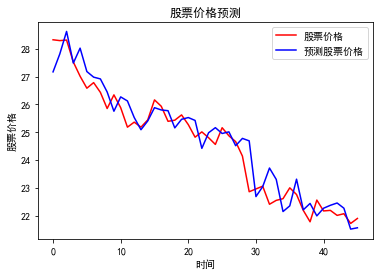

In [20]:
# 画出真实数据和预测数据的对比曲线
plt.plot(real_stock_price, color='red', label='股票价格')
plt.plot(predicted_stock_price, color='blue', label='预测股票价格')
plt.title('股票价格预测')
plt.xlabel('时间')
plt.ylabel('股票价格')
plt.legend()
plt.show()

In [21]:
# 评估
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_stock_price, real_stock_price)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(predicted_stock_price, real_stock_price))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_stock_price, real_stock_price)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)

均方误差: 0.323646
均方根误差: 0.568899
平均绝对误差: 0.439249


In [22]:
#ACC
error = 0
summery = 0
for i in range(24):
    error += abs(predicted_stock_price[i] - real_stock_price[i])
    summery += real_stock_price[i]
acc = 1 - error/summery
print("准确率：{}".format(acc))

准确率：0.9841606630012542
